Implements billiard dynamics of many spherical particles in arbitrary dimension with custom particle-wall and particle-particle collision maps on both CPU and GPU.

Dr. Scott Cook - Tarleton State Univ - Dept of Mathematics

Release notes 2018/04/13
- Only handles cubical chamber.  More general shapes done in prior versions wo/ GPU support.  Plan to implement other shapes here soon.
- Only handles specular reflection law.  More general collision laws done in prior versions wo/ GPU support.  Plan to implement other laws here soon.
- Simulation can run entirely in "serial" mode without GPU hardware (or even without gpu_defs.py).
- "Parallel" mode uses most of the same code as serial.  Main difference is that computation of particle-particle collision times is done on GPU, since that is the $O(n^2)$ calculation ($n$=number of particles).
- Consider computing particle-wall collision time on GPU in the future.  But that is $O(n)$, so it is not clear how much speed up that will provide.
- "Parallel" mode can run with or without verification against CPU using the "check_gpu_against_cpu" variable.  Verification adds significant time and should be used for code validation and debugging.

In [18]:
%run -i billiard_defs.py
errors = 0

### Parameters
NP = np.arange(1,2,1) * sqrt_threads_per_block_max
modes = ['serial', 'parallel']
# modes = ['parallel']
# modes = ['serial']
check_gpu_against_cpu = True#False
run_time = {key:[] for key in modes}
pos = {key:[] for key in modes}

max_steps = 20
max_records = None
try:
    rec_period = int(np.ceil(max_steps / max_records))
except:
    rec_period = 1
if (rec_period < 1) or (rec_period is np.inf):
    rec_period = 1

for num_part in NP:
    for mode in modes:
        seed = 15
        rnd = np.random.RandomState(seed)

        dim = 2
        side = 10

#         wall = []
#         for d in range(dim):
#             for s in [-1,1]:
#                 v = np.zeros(dim, dtype=np_dtype)
#                 v[d] = s*side
#                 wall.append(FlatWall(base_point=v.copy(), normal=-v.copy()
#                                        , tangents = [np.roll(v.copy(),j) for j in range(1,dim)]))

        cell_size = (np.arange(dim)+1)*10
        Tangents = np.diag(cell_size)
        wall = []
        for d in range(dim):
            for s in [-1,1]:
                v = np.zeros(dim, dtype=np_dtype)
                v[d] = s*cell_size[d]
                wall.append(FlatWall(base_point=v.copy(), normal=-v.copy()
                                       , tangents = np.delete(Tangents,d,0)))
    
    
        wall.append(SphereWall(base_point=v*0.0, radius=7))
#         cell_size = [wall[0].base_point[0], wall[2].base_point[1]]
                    
        part = Particles()
        
        # set any parameters, positions, velocities, etc here.  Else default will be used.
        part.mass[:] = 4
        for w in wall[:2]:
            w.gap_m = 0.0
            w.gap_b = 0.0
        wall[0].pw_collision_law = PW_PeriodicLaw(wrap_dim=0, wrap_wall=1)
        wall[1].pw_collision_law = PW_PeriodicLaw(wrap_dim=0, wrap_wall=0)
#         wall[2].pw_collision_law = PW_PeriodicLaw(wrap_dim=1, wrap_wall=3)
#         wall[3].pw_collision_law = PW_PeriodicLaw(wrap_dim=1, wrap_wall=2)
        
        
        
        ## compute radius so that particles take up a fixed proportion of the volume of the box
        density = 0.1
        V_box = side**dim
        V_part_box = density * V_box / num_part  # volume of little box each particle must fit into
        part.radius[:] = (V_part_box)**(1/dim) / 2
        

        start = timer()
        initialize(wall, part)
        if mode == 'parallel':
            %run -i gpu_defs.py
            #exec(open("gpu_defs.py").read())
            load_gpu(part)
        
        for step in range(max_steps):
            next_state(part)
            part.check()
            if mode == 'parallel':
                update_gpu(part)

            if step % rec_period == 0:        
                print('num_part = {}, step = {}, mode = {}'.format(part.num, step, mode))
                part.record_state()
                
        part.clean_up()
        elapsed = timer() - start
        print('Done!! #Particles = {}, Steps = {}, Sim Time = {:2f}, Elapsed Time = {:2f}\n'.format(part.num, step+1, part.t_hist[-1], elapsed))
        run_time[mode].append(elapsed)
        pos[mode].append(part.pos_hist.copy())
#     print(pos['serial'][-1] - pos['parallel'][-1])
#     assert np.allclose(pos['serial'][-1], pos['parallel'][-1], rtol=0.05)

num_part = 32, step = 0, mode = serial
num_part = 32, step = 1, mode = serial
num_part = 32, step = 2, mode = serial
num_part = 32, step = 3, mode = serial
num_part = 32, step = 4, mode = serial
num_part = 32, step = 5, mode = serial
num_part = 32, step = 6, mode = serial
num_part = 32, step = 7, mode = serial
num_part = 32, step = 8, mode = serial
num_part = 32, step = 9, mode = serial
num_part = 32, step = 10, mode = serial
num_part = 32, step = 11, mode = serial
num_part = 32, step = 12, mode = serial
num_part = 32, step = 13, mode = serial
num_part = 32, step = 14, mode = serial
num_part = 32, step = 15, mode = serial
num_part = 32, step = 16, mode = serial
num_part = 32, step = 17, mode = serial
num_part = 32, step = 18, mode = serial
num_part = 32, step = 19, mode = serial
Done!! #Particles = 32, Steps = 20, Sim Time = 4.222101, Elapsed Time = 0.047567

load_gpu
num_part = 32, step = 0, mode = parallel
num_part = 32, step = 1, mode = parallel
num_part = 32, step = 2, mode = paral

In [7]:
if dim != 2:
    raise Exception('only works in 2D')
    
num_steps = len(part.t_hist)

mesh = np.linspace(0,2*np.pi,100)
circle = np.array([np.cos(mesh), np.sin(mesh)])
part_bdy = [r*circle for r in part.radius]

def get_cell_translates(x):
    m = np.ceil(x.min(axis=0).min(axis=0) / cell_size)
    M = np.floor(x.max(axis=0).max(axis=0) / cell_size)    
    z = [np.arange(m[d],M[d]+1)*cell_size[d]*2 for d in range(part.dim)]
    translates = it.product(*z)
    return tuple(translates)


def draw(s=0):
    s %= num_steps
    x = part.pos_hist[:s+1]

    translates = get_cell_translates(x)

    fig, ax = plt.subplots(figsize=[8,8]);
    for trans in translates:
        for w in wall:
            ax.plot(*((w.mesh+trans).T), color='black')
            
    for p in range(part.num):
        ax.plot(*(x[:,p].T), color=part.clr[p])
        bdy = part_bdy[p] + x[-1,p][:,np.newaxis]
        ax.plot(*bdy, color=part.clr[p])
    ax.set_aspect('equal')
    

l = widgets.Layout(width='150px')
step_text = widgets.BoundedIntText(min=0, max=num_steps-1, value=0, layout=l)
step_slider = widgets.IntSlider(min=0, max=num_steps-1, value=0, readout=False, continuous_update=False, layout=l)
play_button = widgets.Play(min=0, max=num_steps-1, step=1, interval=500, layout=l)

widgets.jslink((step_text, 'value'), (step_slider, 'value'))
widgets.jslink((step_text, 'value'), (play_button, 'value'))

img = widgets.interactive_output(draw, {'s':step_text})
display(widgets.HBox([widgets.VBox([step_text, step_slider, play_button]), img]))


HBox(children=(VBox(children=(BoundedIntText(value=0, layout=Layout(width='150px'), max=20), IntSlider(value=0, continuous_update=False, layout=Layout(width='150px'), max=20, readout=False), Play(value=0, interval=500, layout=Layout(width='150px'), max=20))), Output()))

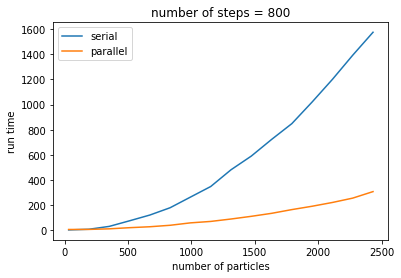

In [2]:
w = min([len(t) for k,t in run_time.items()])
for mode, time in run_time.items():
    plt.plot(NP[:w], run_time[mode][:w], label=mode)
plt.legend()
plt.xlabel('number of particles')
plt.ylabel('run time')
plt.title('number of steps = {}'.format(max_steps))
plt.show()